In [1]:
import requests
import urllib3
from bs4 import BeautifulSoup
import pandas as pd
import re
import pandas_datareader.data as web
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
df = pd.read_csv('stock_headlines_cleaned.csv')
prices = pd.read_csv('stock_prices.csv')
filings = pd.read_csv('filing_dates.csv')

In [3]:
df['date'] = pd.to_datetime(df.date)
prices['date'] = pd.to_datetime(prices.date)
filings['filing_dates'] = pd.to_datetime(filings.filing_dates)

In [5]:
#change price moves into percentage
df['price_move'] = df.price_move * 100

In [7]:
df = df.sort_values('date', ascending = True)
prices = prices.sort_values('date', ascending = True)
filings = filings.sort_values('filing_dates', ascending = True)

In [8]:
#remove stocks with no price movement
df = df[df.price_move != 0]

In [9]:
#copy of events dataframe without removing rows < 20 trading days and within 20 days of next earnings
df_complete = df.copy(deep = True)

In [10]:
len(df_complete)

28089

In [11]:
#remove rows with <= 19 trading days (20 days from previous close date)
price_max_dates = prices.pivot_table(index = 'ticker', values = 'date', aggfunc = 'max').reset_index()
price_max_dates.columns = ['ticker', 'max_date']
df = pd.merge(df, price_max_dates, on = 'ticker', how = 'left', copy = False)
df = df[df.date <= df.max_date - BDay(19)]

del df['max_date']

In [12]:
#check if earnings was reported within 19 days of headline date (20 days from previous close date), if so remove
filings['filing_dates'] = pd.to_datetime(filings.filing_dates)
filings = filings.sort_values('filing_dates')

df = pd.merge_asof(df, filings, by = 'ticker', left_on = 'date', right_on = 'filing_dates', direction = 'forward',
                    allow_exact_matches = False)

#fill missing filing dates with arbitrary old date
df['filing_dates'] = df.filing_dates.fillna(pd.to_datetime('2001-01-01'))
df['days_from_filing'] = np.busday_count(df.date.tolist(), df.filing_dates.tolist())

#remove rows where filing date is within 19 business days (20 days from previous close date) of headline
df = df[df.days_from_filing.abs() > 19]

In [13]:
len(df)

20191

In [14]:
up = df[df.price_move > 0]
down = df[df.price_move < 0]

In [15]:
len(up)

10478

In [16]:
len(down)

9713

In [52]:
#function for getting stocks with certain movement criteria and their price changes 1 month after relative to starting price
def get_price_deviations(df, prices): #prices should be grouped by ticker and then sorted by date
    result = pd.DataFrame({'days':[i for i in range(21)]})
    d = df.to_dict(orient = 'records') #convert to list of dictionaries, iterates faster
    for i in range(len(d)):
        t = d[i]['ticker']
        start_dt = d[i]['date'] - BDay(1)

        p = prices[prices.ticker == t].reset_index(drop = True)
        while len(p[(p.date == start_dt)]) == 0: #if the above calculated start_dt is on a holiday, get last trading day
            start_dt = start_dt - BDay(1)

        #get next 20 trading days prices from start date
        p = p[(p.date >= start_dt) & (p.index <= p[p.date == start_dt].index.values[0] + 20)]

        p = p.sort_values('date')
        

        p['days'] = [i for i in range(0, len(p))]

        start_price = p.close.values[0]

        col_name = t + '_' + str(d[i]['date'])

        p[col_name] = ((p.close / start_price) - 1) * 100
        p = p[[col_name]].reset_index(drop = True)

        result = pd.concat([result, p], axis = 1)
    return(result)

In [53]:
up_30 = up[up.price_move > 30]
up_20_30 = up[(up.price_move > 20) & (up.price_move <= 30)]
up_15_20 = up[(up.price_move > 15) & (up.price_move <= 20)]
up_10_15 = up[(up.price_move > 10) & (up.price_move <= 15)]
up_5_10 = up[(up.price_move > 5) & (up.price_move <= 10)]
up_5 = up[(up.price_move <= 5)]

In [54]:
down_30 = down[down.price_move < -30]
down_20_30 = down[(down.price_move < -20) & (down.price_move >= -30)]
down_15_20 = down[(down.price_move < -15) & (down.price_move >= -20)]
down_10_15 = down[(down.price_move < -10) & (down.price_move >= -15)]
down_5_10 = down[(down.price_move < -5) & (down.price_move >= -10)]
down_5 = down[(down.price_move >= -5)]

In [55]:
%time u_5 = get_price_deviations(up_5, prices[prices.ticker.isin(up_5.ticker)])
%time u_5_10 = get_price_deviations(up_5_10, prices[prices.ticker.isin(up_5_10.ticker)])
%time u_10_15 = get_price_deviations(up_10_15, prices[prices.ticker.isin(up_10_15.ticker)])
%time u_15_20 = get_price_deviations(up_15_20, prices[prices.ticker.isin(up_15_20.ticker)])
%time u_20_30 = get_price_deviations(up_20_30, prices[prices.ticker.isin(up_20_30.ticker)])
%time u_30 = get_price_deviations(up_30, prices[prices.ticker.isin(up_30.ticker)])

CPU times: user 50.3 s, sys: 325 ms, total: 50.6 s
Wall time: 51.7 s
CPU times: user 5min 8s, sys: 1.73 s, total: 5min 10s
Wall time: 5min 18s
CPU times: user 5min 48s, sys: 885 ms, total: 5min 49s
Wall time: 5min 51s
CPU times: user 2min 9s, sys: 367 ms, total: 2min 10s
Wall time: 2min 10s
CPU times: user 1min 15s, sys: 183 ms, total: 1min 15s
Wall time: 1min 16s
CPU times: user 50.9 s, sys: 123 ms, total: 51.1 s
Wall time: 51.2 s


In [56]:
#get average movements
for temp in [u_5, u_5_10, u_10_15, u_15_20, u_20_30, u_30]:
    temp['pct_change_mean'] = temp[[col for col in temp.columns if col != 'days']].mean(1)

In [57]:
%time d_5 = get_price_deviations(down_5, prices[prices.ticker.isin(down_5.ticker)])
%time d_5_10 = get_price_deviations(down_5_10, prices[prices.ticker.isin(down_5_10.ticker)])
%time d_10_15 = get_price_deviations(down_10_15, prices[prices.ticker.isin(down_10_15.ticker)])
%time d_15_20 = get_price_deviations(down_15_20, prices[prices.ticker.isin(down_15_20.ticker)])
%time d_20_30 = get_price_deviations(down_20_30, prices[prices.ticker.isin(down_20_30.ticker)])
%time d_30 = get_price_deviations(down_30, prices[prices.ticker.isin(down_30.ticker)])

CPU times: user 43.8 s, sys: 102 ms, total: 43.9 s
Wall time: 44 s
CPU times: user 4min 51s, sys: 834 ms, total: 4min 51s
Wall time: 4min 55s
CPU times: user 5min 47s, sys: 791 ms, total: 5min 47s
Wall time: 5min 49s
CPU times: user 1min 46s, sys: 278 ms, total: 1min 46s
Wall time: 1min 47s
CPU times: user 57.7 s, sys: 131 ms, total: 57.8 s
Wall time: 58 s
CPU times: user 22.2 s, sys: 47.2 ms, total: 22.3 s
Wall time: 22.3 s


In [58]:
#get average movements
for temp in [d_5, d_5_10, d_10_15, d_15_20, d_20_30, d_30]:
    temp['pct_change_mean'] = temp[[col for col in temp.columns if col != 'days']].mean(1)

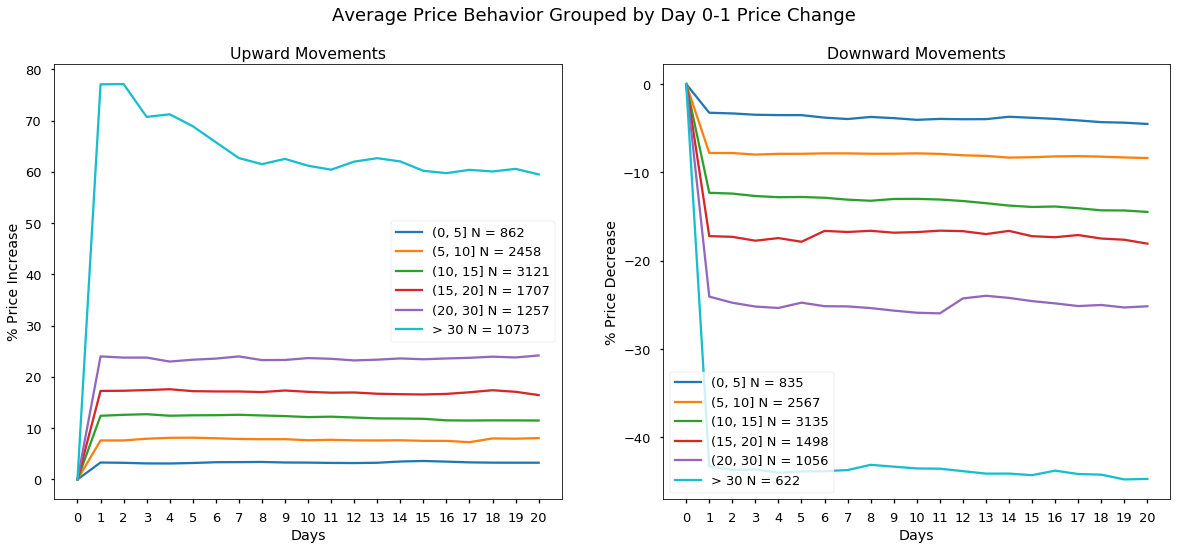

In [59]:
fig, axes = plt.subplots(1, 2)

u_5[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=axes[0], figsize = [20, 8], color = 'tab:blue')
u_5_10[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=axes[0], color = 'tab:orange')
u_10_15[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=axes[0], color = 'tab:green')
u_15_20[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=axes[0], color = 'tab:red')
u_20_30[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=axes[0], color = 'tab:purple')
u_30[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=axes[0], color = 'tab:cyan')

axes[0].set_xticks(range(21))
axes[0].legend(['(0, 5] N = %d'%(u_5.shape[1]-2), '(5, 10] N = %d'%(u_5_10.shape[1]-2), 
            '(10, 15] N = %d'%(u_10_15.shape[1]-2), '(15, 20] N = %d'%(u_15_20.shape[1]-2), 
            '(20, 30] N = %d'%(u_20_30.shape[1]-2),'> 30 N = %d'%(u_30.shape[1]-2)]);

axes[0].set_ylabel('% Price Increase');
axes[0].set_xlabel('Days');

axes[0].set_title('Upward Movements');

d_5[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=axes[1], figsize = [20, 8], color = 'tab:blue')
d_5_10[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=axes[1], color = 'tab:orange')
d_10_15[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=axes[1], color = 'tab:green')
d_15_20[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=axes[1], color = 'tab:red')
d_20_30[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=axes[1], color = 'tab:purple')
d_30[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=axes[1], color = 'tab:cyan')

axes[1].set_xticks(range(21))
axes[1].legend(['(0, 5] N = %d'%(d_5.shape[1]-2), '(5, 10] N = %d'%(d_5_10.shape[1]-2), 
            '(10, 15] N = %d'%(d_10_15.shape[1]-2), '(15, 20] N = %d'%(d_15_20.shape[1]-2), 
            '(20, 30] N = %d'%(d_20_30.shape[1]-2),'> 30 N = %d'%(d_30.shape[1]-2)]);

axes[1].set_ylabel('% Price Decrease');
axes[1].set_xlabel('Days');

axes[1].set_title('Downward Movements');

fig.suptitle('Average Price Behavior Grouped by Day 0-1 Price Change', size = 18);

In [60]:
#another look at > 30 group
up_50 = up[up.price_move > 50]
up_30_50 = up[(up.price_move > 30) & (up.price_move <= 50)]

In [61]:
%time u_30_50 = get_price_deviations(up_30_50, prices[prices.ticker.isin(up_30_50.ticker)])
%time u_50 = get_price_deviations(up_50, prices[prices.ticker.isin(up_50.ticker)])

CPU times: user 23.1 s, sys: 55.7 ms, total: 23.2 s
Wall time: 23.2 s
CPU times: user 11.5 s, sys: 36.9 ms, total: 11.6 s
Wall time: 11.6 s


In [62]:
for temp in [u_30_50, u_50]:
    temp['pct_change_mean'] = temp[[col for col in temp.columns if col != 'days']].mean(1)

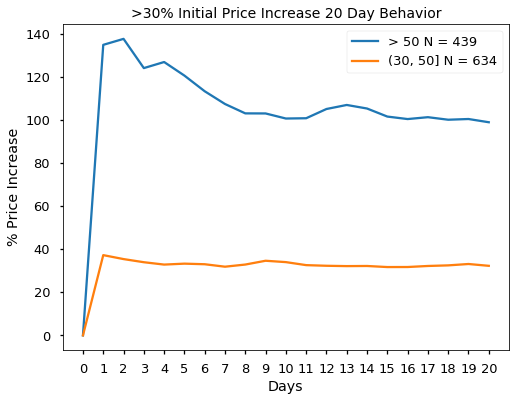

In [121]:
fig = plt.subplot()

u_50[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=fig, figsize = [8, 6], color = 'tab:blue')
u_30_50[['pct_change_mean', 'days']].plot(kind = 'line', x = 'days', ax=fig, color = 'tab:orange')

plt.xticks(range(21));
plt.legend(['> 50 N = %d'%(u_50.shape[1]-2), '(30, 50] N = %d'%(u_30_50.shape[1]-2)]);

plt.ylabel('% Price Increase');
plt.xlabel('Days');

plt.title('>30% Initial Price Increase 20 Day Behavior', size = 14);

In [64]:
#compare stocks with golden crosses

In [65]:
#successful 50-200 golden cross and upward stock movement
%time gcs_30 = get_price_deviations(up_30[(up_30.price_50_dma > up_30.price_200_dma)], prices[prices.ticker.isin(up_30[(up_30.price_50_dma > up_30.price_200_dma)].ticker)])
%time gcs_20_30 = get_price_deviations(up_20_30[(up_20_30.price_50_dma > up_20_30.price_200_dma)], prices[prices.ticker.isin(up_20_30[(up_20_30.price_50_dma > up_20_30.price_200_dma)].ticker)])
%time gcs_15_20 = get_price_deviations(up_15_20[(up_15_20.price_50_dma > up_15_20.price_200_dma)], prices[prices.ticker.isin(up_15_20[(up_15_20.price_50_dma > up_15_20.price_200_dma)].ticker)])
%time gcs_10_15 = get_price_deviations(up_10_15[(up_10_15.price_50_dma > up_10_15.price_200_dma)], prices[prices.ticker.isin(up_10_15[(up_10_15.price_50_dma > up_10_15.price_200_dma)].ticker)])
%time gcs_5_10 = get_price_deviations(up_5_10[(up_5_10.price_50_dma > up_5_10.price_200_dma)], prices[prices.ticker.isin(up_5_10[(up_5_10.price_50_dma > up_5_10.price_200_dma)].ticker)])
%time gcs_5 = get_price_deviations(up_5[(up_5.price_50_dma > up_5.price_200_dma)], prices[prices.ticker.isin(up_5[(up_5.price_50_dma > up_5.price_200_dma)].ticker)])

#unsuccessful 50-200 golden cross and upward stock movement
%time gcf_30 = get_price_deviations(up_30[(up_30.price_50_dma <= up_30.price_200_dma)], prices[prices.ticker.isin(up_30[(up_30.price_50_dma <= up_30.price_200_dma)].ticker)])
%time gcf_20_30 = get_price_deviations(up_20_30[(up_20_30.price_50_dma <= up_20_30.price_200_dma)], prices[prices.ticker.isin(up_20_30[(up_20_30.price_50_dma <= up_20_30.price_200_dma)].ticker)])
%time gcf_15_20 = get_price_deviations(up_15_20[(up_15_20.price_50_dma <= up_15_20.price_200_dma)], prices[prices.ticker.isin(up_15_20[(up_15_20.price_50_dma <= up_15_20.price_200_dma)].ticker)])
%time gcf_10_15 = get_price_deviations(up_10_15[(up_10_15.price_50_dma <= up_10_15.price_200_dma)], prices[prices.ticker.isin(up_10_15[(up_10_15.price_50_dma <= up_10_15.price_200_dma)].ticker)])
%time gcf_5_10 = get_price_deviations(up_5_10[(up_5_10.price_50_dma <= up_5_10.price_200_dma)], prices[prices.ticker.isin(up_5_10[(up_5_10.price_50_dma <= up_5_10.price_200_dma)].ticker)])
%time gcf_5 = get_price_deviations(up_5[(up_5.price_50_dma <= up_5.price_200_dma)], prices[prices.ticker.isin(up_5[(up_5.price_50_dma <= up_5.price_200_dma)].ticker)])

CPU times: user 7.27 s, sys: 221 ms, total: 7.5 s
Wall time: 7.75 s
CPU times: user 17.2 s, sys: 238 ms, total: 17.5 s
Wall time: 21.6 s
CPU times: user 39.9 s, sys: 513 ms, total: 40.5 s
Wall time: 47.6 s
CPU times: user 1min 23s, sys: 1.01 s, total: 1min 24s
Wall time: 1min 30s
CPU times: user 1min 12s, sys: 680 ms, total: 1min 12s
Wall time: 1min 14s
CPU times: user 17.4 s, sys: 106 ms, total: 17.5 s
Wall time: 17.8 s
CPU times: user 24.3 s, sys: 94.2 ms, total: 24.4 s
Wall time: 24.5 s
CPU times: user 28.5 s, sys: 197 ms, total: 28.7 s
Wall time: 28.8 s
CPU times: user 44.6 s, sys: 442 ms, total: 45.1 s
Wall time: 47.2 s
CPU times: user 2min 5s, sys: 1.41 s, total: 2min 6s
Wall time: 2min 12s
CPU times: user 1min 25s, sys: 743 ms, total: 1min 26s
Wall time: 1min 29s
CPU times: user 10.7 s, sys: 121 ms, total: 10.8 s
Wall time: 11.2 s


In [66]:
#successful 50-200 death cross and downward stock movement
%time dcs_30 = get_price_deviations(down_30[(down_30.price_50_dma < down_30.price_200_dma)], prices[prices.ticker.isin(down_30[(down_30.price_50_dma < down_30.price_200_dma)].ticker)])
%time dcs_20_30 = get_price_deviations(down_20_30[(down_20_30.price_50_dma < down_20_30.price_200_dma)], prices[prices.ticker.isin(down_20_30[(down_20_30.price_50_dma < down_20_30.price_200_dma)].ticker)])
%time dcs_15_20 = get_price_deviations(down_15_20[(down_15_20.price_50_dma < down_15_20.price_200_dma)], prices[prices.ticker.isin(down_15_20[(down_15_20.price_50_dma < down_15_20.price_200_dma)].ticker)])
%time dcs_10_15 = get_price_deviations(down_10_15[(down_10_15.price_50_dma < down_10_15.price_200_dma)], prices[prices.ticker.isin(down_10_15[(down_10_15.price_50_dma < down_10_15.price_200_dma)].ticker)])
%time dcs_5_10 = get_price_deviations(down_5_10[(down_5_10.price_50_dma < down_5_10.price_200_dma)], prices[prices.ticker.isin(down_5_10[(down_5_10.price_50_dma < down_5_10.price_200_dma)].ticker)])
%time dcs_5 = get_price_deviations(down_5[(down_5.price_50_dma < down_5.price_200_dma)], prices[prices.ticker.isin(down_5[(down_5.price_50_dma < down_5.price_200_dma)].ticker)])

#unsuccessful 50-200 death cross and downward stock movement
%time dcf_30 = get_price_deviations(down_30[(down_30.price_50_dma >= down_30.price_200_dma)], prices[prices.ticker.isin(down_30[(down_30.price_50_dma >= down_30.price_200_dma)].ticker)])
%time dcf_20_30 = get_price_deviations(down_20_30[(down_20_30.price_50_dma >= down_20_30.price_200_dma)], prices[prices.ticker.isin(down_20_30[(down_20_30.price_50_dma >= down_20_30.price_200_dma)].ticker)])
%time dcf_15_20 = get_price_deviations(down_15_20[(down_15_20.price_50_dma >= down_15_20.price_200_dma)], prices[prices.ticker.isin(down_15_20[(down_15_20.price_50_dma >= down_15_20.price_200_dma)].ticker)])
%time dcf_10_15 = get_price_deviations(down_10_15[(down_10_15.price_50_dma >= down_10_15.price_200_dma)], prices[prices.ticker.isin(down_10_15[(down_10_15.price_50_dma >= down_10_15.price_200_dma)].ticker)])
%time dcf_5_10 = get_price_deviations(down_5_10[(down_5_10.price_50_dma >= down_5_10.price_200_dma)], prices[prices.ticker.isin(down_5_10[(down_5_10.price_50_dma >= down_5_10.price_200_dma)].ticker)])
%time dcf_5 = get_price_deviations(down_5[(down_5.price_50_dma >= down_5.price_200_dma)], prices[prices.ticker.isin(down_5[(down_5.price_50_dma >= down_5.price_200_dma)].ticker)])

CPU times: user 11 s, sys: 102 ms, total: 11.1 s
Wall time: 11.3 s
CPU times: user 23.2 s, sys: 179 ms, total: 23.4 s
Wall time: 24 s
CPU times: user 40.2 s, sys: 418 ms, total: 40.7 s
Wall time: 42.3 s
CPU times: user 2min 2s, sys: 984 ms, total: 2min 3s
Wall time: 2min 6s
CPU times: user 1min 25s, sys: 805 ms, total: 1min 25s
Wall time: 1min 28s
CPU times: user 11.9 s, sys: 156 ms, total: 12.1 s
Wall time: 12.5 s
CPU times: user 4.87 s, sys: 71.5 ms, total: 4.94 s
Wall time: 5.21 s
CPU times: user 11.4 s, sys: 75.9 ms, total: 11.5 s
Wall time: 11.7 s
CPU times: user 22.1 s, sys: 191 ms, total: 22.3 s
Wall time: 22.8 s
CPU times: user 1min 20s, sys: 709 ms, total: 1min 20s
Wall time: 1min 22s
CPU times: user 1min 19s, sys: 483 ms, total: 1min 20s
Wall time: 1min 21s
CPU times: user 15.2 s, sys: 96.4 ms, total: 15.3 s
Wall time: 15.6 s


In [67]:
cross_ls = [gcs_30, gcs_20_30, gcs_15_20, gcs_10_15, gcs_5_10, gcs_5, 
            gcf_30, gcf_20_30, gcf_15_20, gcf_10_15, gcf_5_10, gcf_5,
            dcs_30, dcs_20_30, dcs_15_20, dcs_10_15, dcs_5_10, dcs_5, 
            dcf_30, dcf_20_30, dcf_15_20, dcf_10_15, dcf_5_10, dcf_5]

#get average movements
for temp in cross_ls:
    temp['pct_change_mean'] = temp[[col for col in temp.columns if col != 'days']].mean(1)

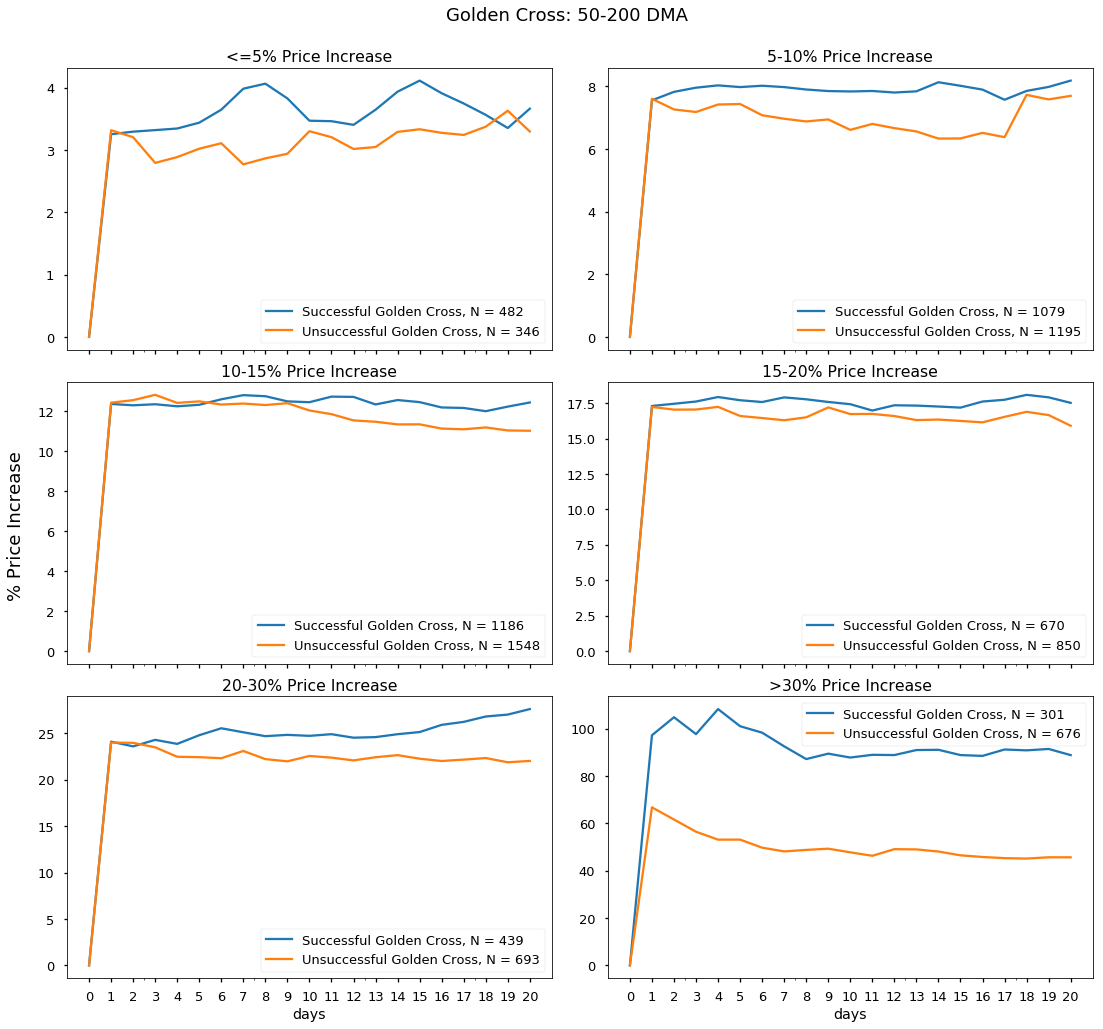

In [75]:
fig, axes = plt.subplots(3, 2, sharex = True)

#golden cross, price <= 5% increase
gcs_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0], figsize = [15, 15])
gcf_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0])
axes[0,0].legend(['Successful Golden Cross, N = %d'%(gcs_5.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf_5.shape[1]-2)])
axes[0,0].set_xticks(range(21))
axes[0,0].set_title('<=5% Price Increase')

#golden cross, price 5-10% increase
gcs_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
gcf_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
axes[0,1].legend(['Successful Golden Cross, N = %d'%(gcs_5_10.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf_5_10.shape[1]-2)])
axes[0,1].set_xticks(range(21));
axes[0,1].set_title('5-10% Price Increase')


#golden cross, price 10-15% increase
gcs_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
gcf_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
axes[1,0].legend(['Successful Golden Cross, N = %d'%(gcs_10_15.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf_10_15.shape[1]-2)])
axes[1,0].set_xticks(range(21));
axes[1,0].set_title('10-15% Price Increase')


#golden cross, price 15-20% increase
gcs_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
gcf_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
axes[1,1].legend(['Successful Golden Cross, N = %d'%(gcs_15_20.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf_15_20.shape[1]-2)])
axes[1,1].set_xticks(range(21));
axes[1,1].set_title('15-20% Price Increase')


#golden cross, price 20-30% increase
gcs_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
gcf_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
axes[2,0].legend(['Successful Golden Cross, N = %d'%(gcs_20_30.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf_20_30.shape[1]-2)])
axes[2,0].set_xticks(range(21));
axes[2,0].set_title('20-30% Price Increase')


#golden cross, price > 30% increase
gcs_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
gcf_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
axes[2,1].legend(['Successful Golden Cross, N = %d'%(gcs_30.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf_30.shape[1]-2)])
axes[2,1].set_xticks(range(21));
axes[2,1].set_title('>30% Price Increase');

fig.suptitle('Golden Cross: 50-200 DMA', size = 18);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.text(-0.01, 0.5, '% Price Increase', ha='center', va='center', rotation='vertical', size = 18);


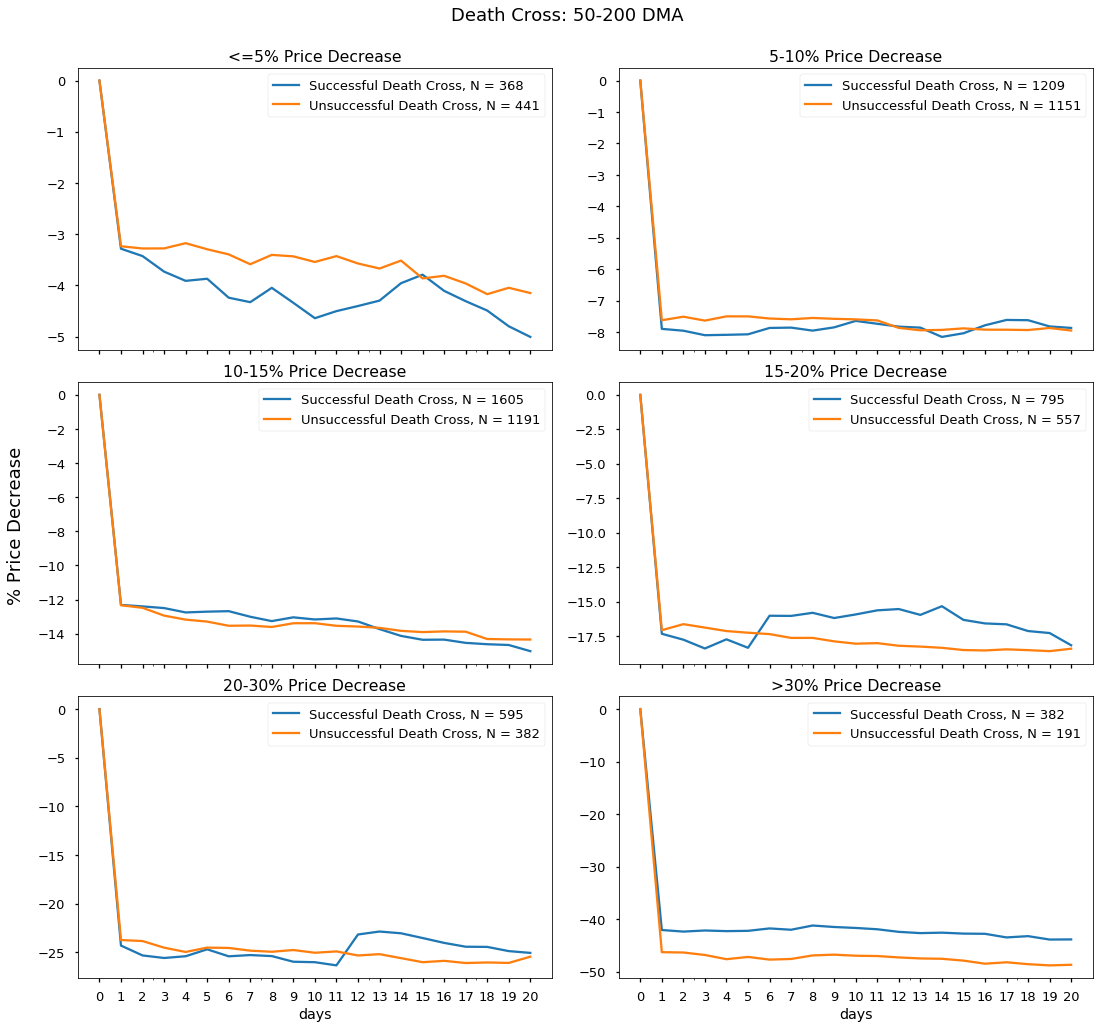

In [76]:
fig, axes = plt.subplots(3, 2, sharex = True)

#Death cross, price <= 5% Decrease
dcs_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0], figsize = [15, 15])
dcf_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0])
axes[0,0].legend(['Successful Death Cross, N = %d'%(dcs_5.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf_5.shape[1]-2)])
axes[0,0].set_xticks(range(21))
axes[0,0].set_title('<=5% Price Decrease')

#Death cross, price 5-10% Decrease
dcs_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
dcf_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
axes[0,1].legend(['Successful Death Cross, N = %d'%(dcs_5_10.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf_5_10.shape[1]-2)])
axes[0,1].set_xticks(range(21));
axes[0,1].set_title('5-10% Price Decrease')


#Death cross, price 10-15% Decrease
dcs_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
dcf_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
axes[1,0].legend(['Successful Death Cross, N = %d'%(dcs_10_15.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf_10_15.shape[1]-2)])
axes[1,0].set_xticks(range(21));
axes[1,0].set_title('10-15% Price Decrease')


#Death cross, price 15-20% Decrease
dcs_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
dcf_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
axes[1,1].legend(['Successful Death Cross, N = %d'%(dcs_15_20.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf_15_20.shape[1]-2)])
axes[1,1].set_xticks(range(21));
axes[1,1].set_title('15-20% Price Decrease')


#Death cross, price 20-30% Decrease
dcs_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
dcf_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
axes[2,0].legend(['Successful Death Cross, N = %d'%(dcs_20_30.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf_20_30.shape[1]-2)])
axes[2,0].set_xticks(range(21));
axes[2,0].set_title('20-30% Price Decrease')


#Death cross, price > 30% Decrease
dcs_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
dcf_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
axes[2,1].legend(['Successful Death Cross, N = %d'%(dcs_30.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf_30.shape[1]-2)])
axes[2,1].set_xticks(range(21));
axes[2,1].set_title('>30% Price Decrease');

fig.suptitle('Death Cross: 50-200 DMA', size = 18);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.text(-0.01, 0.5, '% Price Decrease', ha='center', va='center', rotation='vertical', size = 18);


In [70]:
#successful 5-20 golden cross and upward stock movement
%time gcs2_30 = get_price_deviations(up_30[(up_30.price_5_dma > up_30.price_20_dma)], prices[prices.ticker.isin(up_30[(up_30.price_5_dma > up_30.price_20_dma)].ticker)])
%time gcs2_20_30 = get_price_deviations(up_20_30[(up_20_30.price_5_dma > up_20_30.price_20_dma)], prices[prices.ticker.isin(up_20_30[(up_20_30.price_5_dma > up_20_30.price_20_dma)].ticker)])
%time gcs2_15_20 = get_price_deviations(up_15_20[(up_15_20.price_5_dma > up_15_20.price_20_dma)], prices[prices.ticker.isin(up_15_20[(up_15_20.price_5_dma > up_15_20.price_20_dma)].ticker)])
%time gcs2_10_15 = get_price_deviations(up_10_15[(up_10_15.price_5_dma > up_10_15.price_20_dma)], prices[prices.ticker.isin(up_10_15[(up_10_15.price_5_dma > up_10_15.price_20_dma)].ticker)])
%time gcs2_5_10 = get_price_deviations(up_5_10[(up_5_10.price_5_dma > up_5_10.price_20_dma)], prices[prices.ticker.isin(up_5_10[(up_5_10.price_5_dma > up_5_10.price_20_dma)].ticker)])
%time gcs2_5 = get_price_deviations(up_5[(up_5.price_5_dma > up_5.price_20_dma)], prices[prices.ticker.isin(up_5[(up_5.price_5_dma > up_5.price_20_dma)].ticker)])

#unsuccessful 5-20 golden cross and upward stock movement
%time gcf2_30 = get_price_deviations(up_30[(up_30.price_5_dma <= up_30.price_20_dma)], prices[prices.ticker.isin(up_30[(up_30.price_5_dma <= up_30.price_20_dma)].ticker)])
%time gcf2_20_30 = get_price_deviations(up_20_30[(up_20_30.price_5_dma <= up_20_30.price_20_dma)], prices[prices.ticker.isin(up_20_30[(up_20_30.price_5_dma <= up_20_30.price_20_dma)].ticker)])
%time gcf2_15_20 = get_price_deviations(up_15_20[(up_15_20.price_5_dma <= up_15_20.price_20_dma)], prices[prices.ticker.isin(up_15_20[(up_15_20.price_5_dma <= up_15_20.price_20_dma)].ticker)])
%time gcf2_10_15 = get_price_deviations(up_10_15[(up_10_15.price_5_dma <= up_10_15.price_20_dma)], prices[prices.ticker.isin(up_10_15[(up_10_15.price_5_dma <= up_10_15.price_20_dma)].ticker)])
%time gcf2_5_10 = get_price_deviations(up_5_10[(up_5_10.price_5_dma <= up_5_10.price_20_dma)], prices[prices.ticker.isin(up_5_10[(up_5_10.price_5_dma <= up_5_10.price_20_dma)].ticker)])
%time gcf2_5 = get_price_deviations(up_5[(up_5.price_5_dma <= up_5.price_20_dma)], prices[prices.ticker.isin(up_5[(up_5.price_5_dma <= up_5.price_20_dma)].ticker)])

CPU times: user 33.8 s, sys: 274 ms, total: 34.1 s
Wall time: 34.7 s
CPU times: user 41 s, sys: 286 ms, total: 41.2 s
Wall time: 41.8 s
CPU times: user 1min 8s, sys: 844 ms, total: 1min 9s
Wall time: 1min 14s
CPU times: user 2min 47s, sys: 697 ms, total: 2min 47s
Wall time: 2min 49s
CPU times: user 1min 59s, sys: 961 ms, total: 2min
Wall time: 2min 3s
CPU times: user 20.8 s, sys: 206 ms, total: 21 s
Wall time: 21.8 s
CPU times: user 5.52 s, sys: 56.3 ms, total: 5.58 s
Wall time: 5.66 s
CPU times: user 11.7 s, sys: 144 ms, total: 11.9 s
Wall time: 12.4 s
CPU times: user 23.8 s, sys: 171 ms, total: 23.9 s
Wall time: 24.2 s
CPU times: user 1min 5s, sys: 398 ms, total: 1min 6s
Wall time: 1min 7s
CPU times: user 56.4 s, sys: 303 ms, total: 56.7 s
Wall time: 57.2 s
CPU times: user 9.69 s, sys: 56 ms, total: 9.74 s
Wall time: 9.81 s


In [71]:
#successful 5-20 death cross and downward stock movement
%time dcs2_30 = get_price_deviations(down_30[(down_30.price_5_dma < down_30.price_20_dma)], prices[prices.ticker.isin(down_30[(down_30.price_5_dma < down_30.price_20_dma)].ticker)])
%time dcs2_20_30 = get_price_deviations(down_20_30[(down_20_30.price_5_dma < down_20_30.price_20_dma)], prices[prices.ticker.isin(down_20_30[(down_20_30.price_5_dma < down_20_30.price_20_dma)].ticker)])
%time dcs2_15_20 = get_price_deviations(down_15_20[(down_15_20.price_5_dma < down_15_20.price_20_dma)], prices[prices.ticker.isin(down_15_20[(down_15_20.price_5_dma < down_15_20.price_20_dma)].ticker)])
%time dcs2_10_15 = get_price_deviations(down_10_15[(down_10_15.price_5_dma < down_10_15.price_20_dma)], prices[prices.ticker.isin(down_10_15[(down_10_15.price_5_dma < down_10_15.price_20_dma)].ticker)])
%time dcs2_5_10 = get_price_deviations(down_5_10[(down_5_10.price_5_dma < down_5_10.price_20_dma)], prices[prices.ticker.isin(down_5_10[(down_5_10.price_5_dma < down_5_10.price_20_dma)].ticker)])
%time dcs2_5 = get_price_deviations(down_5[(down_5.price_5_dma < down_5.price_20_dma)], prices[prices.ticker.isin(down_5[(down_5.price_5_dma < down_5.price_20_dma)].ticker)])

#unsuccessful 5-20 death cross and downward stock movement
%time dcf2_30 = get_price_deviations(down_30[(down_30.price_5_dma >= down_30.price_20_dma)], prices[prices.ticker.isin(down_30[(down_30.price_5_dma >= down_30.price_20_dma)].ticker)])
%time dcf2_20_30 = get_price_deviations(down_20_30[(down_20_30.price_5_dma >= down_20_30.price_20_dma)], prices[prices.ticker.isin(down_20_30[(down_20_30.price_5_dma >= down_20_30.price_20_dma)].ticker)])
%time dcf2_15_20 = get_price_deviations(down_15_20[(down_15_20.price_5_dma >= down_15_20.price_20_dma)], prices[prices.ticker.isin(down_15_20[(down_15_20.price_5_dma >= down_15_20.price_20_dma)].ticker)])
%time dcf2_10_15 = get_price_deviations(down_10_15[(down_10_15.price_5_dma >= down_10_15.price_20_dma)], prices[prices.ticker.isin(down_10_15[(down_10_15.price_5_dma >= down_10_15.price_20_dma)].ticker)])
%time dcf2_5_10 = get_price_deviations(down_5_10[(down_5_10.price_5_dma >= down_5_10.price_20_dma)], prices[prices.ticker.isin(down_5_10[(down_5_10.price_5_dma >= down_5_10.price_20_dma)].ticker)])
%time dcf2_5 = get_price_deviations(down_5[(down_5.price_5_dma >= down_5.price_20_dma)], prices[prices.ticker.isin(down_5[(down_5.price_5_dma >= down_5.price_20_dma)].ticker)])

CPU times: user 14.4 s, sys: 243 ms, total: 14.7 s
Wall time: 15.2 s
CPU times: user 29.7 s, sys: 180 ms, total: 29.9 s
Wall time: 30.3 s
CPU times: user 43.3 s, sys: 177 ms, total: 43.5 s
Wall time: 43.8 s
CPU times: user 2min 24s, sys: 526 ms, total: 2min 25s
Wall time: 2min 26s
CPU times: user 1min 33s, sys: 196 ms, total: 1min 33s
Wall time: 1min 34s
CPU times: user 12.6 s, sys: 38.5 ms, total: 12.7 s
Wall time: 12.7 s
CPU times: user 3.14 s, sys: 13.1 ms, total: 3.16 s
Wall time: 3.16 s
CPU times: user 8.81 s, sys: 27.1 ms, total: 8.84 s
Wall time: 8.86 s
CPU times: user 22.5 s, sys: 69.4 ms, total: 22.6 s
Wall time: 22.6 s
CPU times: user 1min 21s, sys: 241 ms, total: 1min 21s
Wall time: 1min 21s
CPU times: user 1min 23s, sys: 224 ms, total: 1min 23s
Wall time: 1min 24s
CPU times: user 14 s, sys: 43.6 ms, total: 14 s
Wall time: 14.1 s


In [72]:
cross_ls = [gcs2_30, gcs2_20_30, gcs2_15_20, gcs2_10_15, gcs2_5_10, gcs2_5, 
            gcf2_30, gcf2_20_30, gcf2_15_20, gcf2_10_15, gcf2_5_10, gcf2_5,
            dcs2_30, dcs2_20_30, dcs2_15_20, dcs2_10_15, dcs2_5_10, dcs2_5, 
            dcf2_30, dcf2_20_30, dcf2_15_20, dcf2_10_15, dcf2_5_10, dcf2_5]

#get average movements
for temp in cross_ls:
    temp['pct_change_mean'] = temp[[col for col in temp.columns if col != 'days']].mean(1)

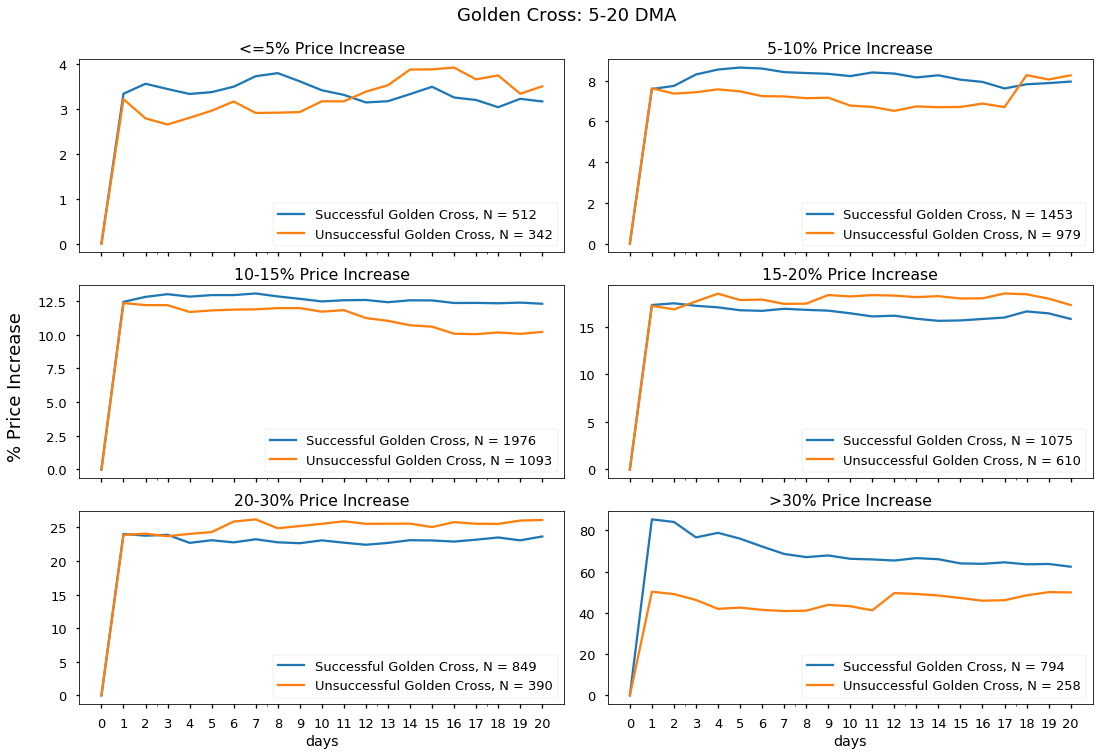

In [77]:
fig, axes = plt.subplots(3, 2, sharex = True)

#golden cross, price <= 5% increase
gcs2_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0], figsize = [15, 11])
gcf2_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0])
axes[0,0].legend(['Successful Golden Cross, N = %d'%(gcs2_5.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf2_5.shape[1]-2)])
axes[0,0].set_xticks(range(21))
axes[0,0].set_title('<=5% Price Increase')

#golden cross, price 5-10% increase
gcs2_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
gcf2_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
axes[0,1].legend(['Successful Golden Cross, N = %d'%(gcs2_5_10.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf2_5_10.shape[1]-2)])
axes[0,1].set_xticks(range(21));
axes[0,1].set_title('5-10% Price Increase')


#golden cross, price 10-15% increase
gcs2_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
gcf2_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
axes[1,0].legend(['Successful Golden Cross, N = %d'%(gcs2_10_15.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf2_10_15.shape[1]-2)])
axes[1,0].set_xticks(range(21));
axes[1,0].set_title('10-15% Price Increase')


#golden cross, price 15-20% increase
gcs2_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
gcf2_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
axes[1,1].legend(['Successful Golden Cross, N = %d'%(gcs2_15_20.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf2_15_20.shape[1]-2)])
axes[1,1].set_xticks(range(21));
axes[1,1].set_title('15-20% Price Increase')


#golden cross, price 20-30% increase
gcs2_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
gcf2_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
axes[2,0].legend(['Successful Golden Cross, N = %d'%(gcs2_20_30.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf2_20_30.shape[1]-2)])
axes[2,0].set_xticks(range(21));
axes[2,0].set_title('20-30% Price Increase')


#golden cross, price > 30% increase
gcs2_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
gcf2_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
axes[2,1].legend(['Successful Golden Cross, N = %d'%(gcs2_30.shape[1]-2), 'Unsuccessful Golden Cross, N = %d'%(gcf2_30.shape[1]-2)])
axes[2,1].set_xticks(range(21));
axes[2,1].set_title('>30% Price Increase');

fig.suptitle('Golden Cross: 5-20 DMA', size = 18);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.text(-0.01, 0.5, '% Price Increase', ha='center', va='center', rotation='vertical', size = 18);


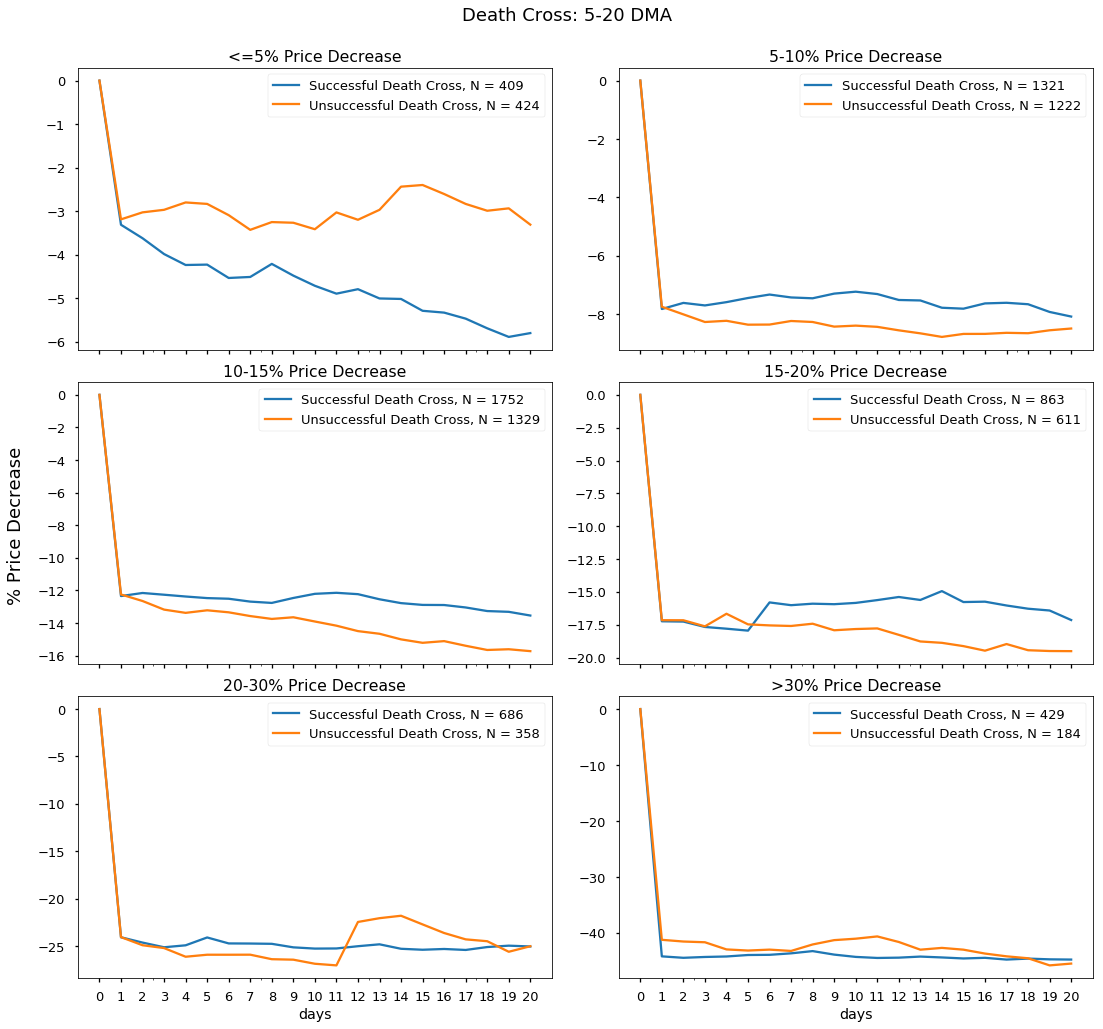

In [79]:
fig, axes = plt.subplots(3, 2, sharex=True)

#Death cross, price <= 5% Decrease
dcs2_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0], figsize = [15, 15])
dcf2_5[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0])
axes[0,0].legend(['Successful Death Cross, N = %d'%(dcs2_5.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf2_5.shape[1]-2)])
axes[0,0].set_xticks(range(21))
axes[0,0].set_title('<=5% Price Decrease')

#Death cross, price 5-10% Decrease
dcs2_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
dcf2_5_10[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
axes[0,1].legend(['Successful Death Cross, N = %d'%(dcs2_5_10.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf2_5_10.shape[1]-2)])
axes[0,1].set_xticks(range(21));
axes[0,1].set_title('5-10% Price Decrease')


#Death cross, price 10-15% Decrease
dcs2_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
dcf2_10_15[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
axes[1,0].legend(['Successful Death Cross, N = %d'%(dcs2_10_15.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf2_10_15.shape[1]-2)])
axes[1,0].set_xticks(range(21));
axes[1,0].set_title('10-15% Price Decrease')


#Death cross, price 15-20% Decrease
dcs2_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
dcf2_15_20[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
axes[1,1].legend(['Successful Death Cross, N = %d'%(dcs2_15_20.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf2_15_20.shape[1]-2)])
axes[1,1].set_xticks(range(21));
axes[1,1].set_title('15-20% Price Decrease')


#Death cross, price 20-30% Decrease
dcs2_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
dcf2_20_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
axes[2,0].legend(['Successful Death Cross, N = %d'%(dcs2_20_30.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf2_20_30.shape[1]-2)])
axes[2,0].set_xticks(range(21));
axes[2,0].set_title('20-30% Price Decrease')


#Death cross, price > 30% Decrease
dcs2_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
dcf2_30[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
axes[2,1].legend(['Successful Death Cross, N = %d'%(dcs2_30.shape[1]-2), 'Unsuccessful Death Cross, N = %d'%(dcf2_30.shape[1]-2)])
axes[2,1].set_xticks(range(21));
axes[2,1].set_title('>30% Price Decrease');

fig.suptitle('Death Cross: 5-20 DMA', size = 18);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.text(-0.01, 0.5, '% Price Decrease', ha='center', va='center', rotation='vertical', size = 18);


In [80]:
#look at increases/decreases in volume along with price increases

#volume < 50DMA
%time vcu_b = get_price_deviations(up[up.cur_day_volume < up.volume_50_dma], prices[prices.ticker.isin(up[up.cur_day_volume < up.volume_50_dma].ticker)])
#volume >= 50DMA
%time vcu_a = get_price_deviations(up[up.cur_day_volume >= up.volume_50_dma], prices[prices.ticker.isin(up[up.cur_day_volume >= up.volume_50_dma].ticker)])

CPU times: user 20 s, sys: 292 ms, total: 20.3 s
Wall time: 21 s
CPU times: user 32min 27s, sys: 5.39 s, total: 32min 32s
Wall time: 32min 42s


In [81]:
vcu_b['pct_change_mean'] = vcu_b[[col for col in vcu_b.columns if col != 'days']].mean(1)
vcu_a['pct_change_mean'] = vcu_a[[col for col in vcu_a.columns if col != 'days']].mean(1)

In [82]:
#volume < 50DMA
%time vcd_b = get_price_deviations(down[down.cur_day_volume < down.volume_50_dma], prices[prices.ticker.isin(down[down.cur_day_volume < down.volume_50_dma].ticker)])
#volume >= 50DMA
%time vcd_a = get_price_deviations(down[down.cur_day_volume >= down.volume_50_dma], prices[prices.ticker.isin(down[down.cur_day_volume >= down.volume_50_dma].ticker)])

CPU times: user 25.5 s, sys: 180 ms, total: 25.7 s
Wall time: 25.8 s
CPU times: user 28min 1s, sys: 3.78 s, total: 28min 5s
Wall time: 28min 9s


In [83]:
vcd_b['pct_change_mean'] = vcd_b[[col for col in vcd_b.columns if col != 'days']].mean(1)
vcd_a['pct_change_mean'] = vcd_a[[col for col in vcd_a.columns if col != 'days']].mean(1)

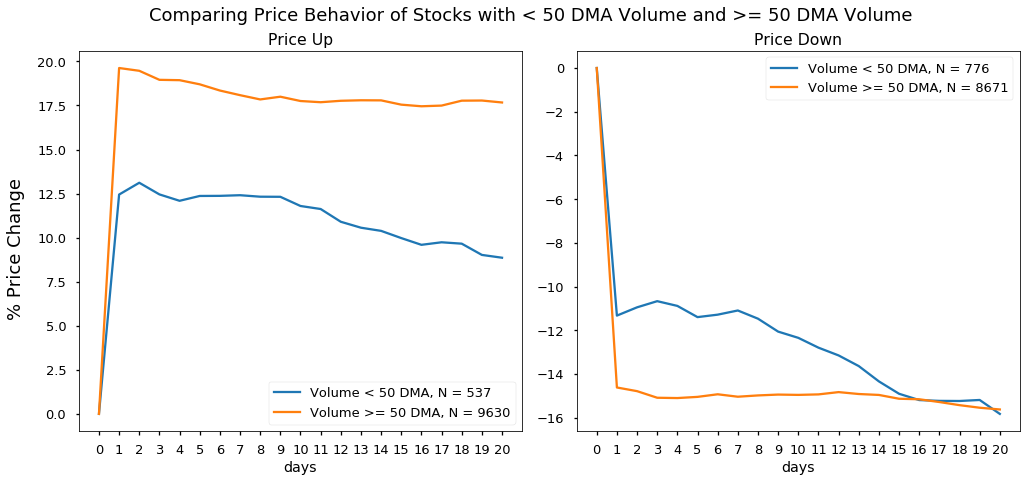

In [84]:
fig, axes = plt.subplots(1, 2)

vcu_b[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0], figsize = [14, 7])
vcu_a[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0])

vcd_b[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1])
vcd_a[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1])

axes[0].legend(['Volume < 50 DMA, N = %d'%(vcu_b.shape[1]-2), 'Volume >= 50 DMA, N = %d'%(vcu_a.shape[1]-2)])
axes[1].legend(['Volume < 50 DMA, N = %d'%(vcd_b.shape[1]-2), 'Volume >= 50 DMA, N = %d'%(vcd_a.shape[1]-2)])

axes[0].set_title('Price Up')
axes[1].set_title('Price Down')

axes[0].set_xticks(range(21));
axes[1].set_xticks(range(21));


fig.suptitle('Comparing Price Behavior of Stocks with < 50 DMA Volume and >= 50 DMA Volume', size = 18)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.text(-0.01, 0.5, '% Price Change', ha='center', va='center', rotation='vertical', size = 18);


In [85]:
#description regex
exec_changes = '''(\Wappoint|\Wname|resign|promote|step down|stepped down|stepping down|retire|replace|depart|\Wnew\W|outgoing|incoming|leaving|left|leave|assume|transition|succeed).*(\Wceo\W|\Wcfo\W|\Wcoo\W|\Wcto\W|director|executive|president|chief|chair|manager)|(\Wceo\W|\Wcfo\W|\Wcoo\W|\Wcto\W|director|executive|president|chief|chair|manager).*(\Wappoint|\Wname|resign|promote|step down|stepped down|retire|replace|depart|\Wnew\W|outgoing|incoming|leaving|left|leave|assume|transition|stepping down|succeed)'''
pharma_approvals = '''fda|food and drug|trial|phase|clinical|placebo|study|Orphan Drug|new drug (submission|application)|pdufa|European Medicines Agency|\WEMA\W|patient|in (vivo|vitro)|(new|updated|reported) data|endpoint|top line (results|data)|efficacy|(pharma|bio|neuro|medic|drug|treatment|therap|oncolog|immun|disease|pdufa|progress|safe|regulat|\Wstage|positive|negative|efficacy|significant|success|cancer|new data).*(patent|drug|cancer|disease)|(patent|drug|cancer|disease).*(pharma|bio|neuro|medic|drug|treatment|therap|oncolog|immun|disease|pdufa|progress|safe|regulat|\Wstage|positive|negative|efficacy|significant|success|cancer|new data)'''
crypto = '''blockchain|cryptocurrency|bitcoin|crypto\W'''
legal = '''lawsuit|ruling|ruled|legal|judge|\Wcourt|\Wjury|arbitration|infringe|litigation|settlement|class action|wrongdoing|settle|verdict'''
earnings = 'earnings|Q4|Q3|Q2|Q1|guidance|\Weps\W|(first|second|third|fourth) quarter|(first|second|third|fourth)-quarter|forecast|upbeat|downbeat|than-expected|(\Wpost|report).*(quarterly|fiscal year|profit|income|revenue|loss|cash flow)|\WFY[^a-zA-Z]|quarterly (profit|result)|(financial|operating) results'
analyst_ratings = '(buy|sell|hold|neutral|overweight|underweight|Equal-weight|Outperform|underperform) rating|initiat(ed|ing) coverage|(buy|sell|hold|neutral|overweight|underweight|Equal-weight|Outperform|underperform) to (buy|sell|hold|neutral|overweight|underweight|Equal-weight|Outperform|underperform)|(up|down)grade|price target|conviction buy'
merge_acq = 'merge|acquisition|acquir|purchased by|\\Wmerging|(buy|sell|purchase) the company|sell itself|to (sell|buy).*deal|go-private|go private|takeover|\Wpurchase of [a-zA-Z]|\Wsale of [a-zA-Z]|agreed to (sell|buy)|buyout|selling itself|(possible|potential) (sale|deal)|offer from|unsolicited|going private|will (buy|sell) [^(back)0-9]'
buyback_dividend = 'repurchase|buyback|buy back|dividend|cash distribution'
deals = 'agreement|deal with|licensed|licensing|license (deal|to|from)|contract|memorandum of|letter of|purchase order|collaborat|strategic deal|partnership|partner with|cooperation'
stake = '\Wstake\W|13(F|G)|investment in the company|(minority|majority|strategic) investment'
offering = 'offering|(pricing|priced).*(stock|notes|financing)|(plans|plan) to offer.*common stock'

In [86]:
#use dataframe of all events (including those previously removed)
df_complete['exec_change'] = 0
df_complete.loc[df_complete.descriptions.str.contains(exec_changes, case = False, na=False), 'exec_change'] = 1

df_complete['pharma_approval'] = 0
df_complete.loc[df_complete.descriptions.str.contains(pharma_approvals, case = False, na=False), 'pharma_approval'] = 1

df_complete['crypto'] = 0
df_complete.loc[df_complete.descriptions.str.contains(crypto, case = False, na=False), 'crypto'] = 1

df_complete['legal'] = 0
df_complete.loc[df_complete.descriptions.str.contains(legal, case = False, na=False), 'legal'] = 1

df_complete['merge_acq'] = 0
df_complete.loc[df_complete.descriptions.str.contains(merge_acq, case = False, na=False), 'merge_acq'] = 1

df_complete['buyback_dividend'] = 0
df_complete.loc[df_complete.descriptions.str.contains(buyback_dividend, case = False, na=False), 'buyback_dividend'] = 1

df_complete['deal'] = 0
df_complete.loc[df_complete.descriptions.str.contains(deals, case = False, na=False), 'deal'] = 1

df_complete['investment_stake'] = 0
df_complete.loc[df_complete.descriptions.str.contains(stake, case = False, na=False), 'investment_stake'] = 1

df_complete['stock_offering'] = 0
df_complete.loc[(df_complete.descriptions.str.contains(offering, case = False, na=False)) & 
                 (df_complete.descriptions.str.contains('\Wipo\W|public offering', case = False, na=False)), 'stock_offering'] = 1

df_complete['amazon_effect'] = 0
df_complete.loc[(df_complete.descriptions.str.contains('amazon', case = False, na=False)) & 
       (df_complete.ticker != 'AMZN'), 'amazon_effect'] = 1


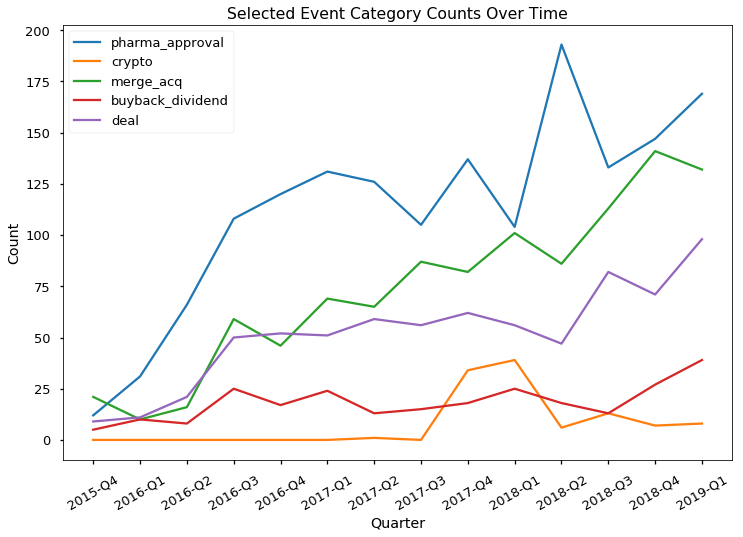

In [87]:
event_cal = df_complete.groupby(pd.Grouper(freq="Q", key = 'date')).sum()[['pharma_approval', 'crypto',
       'merge_acq', 'buyback_dividend', 'deal']]
#only use complete quarters
event_cal = event_cal[event_cal.index <= pd.to_datetime('2019-03-31')]
fig = plt.subplot()
event_cal.plot(ax = fig, figsize = [12, 8])

plt.xticks(event_cal.index,['2015-Q4', '2016-Q1', '2016-Q2', '2016-Q3', '2016-Q4', '2017-Q1', '2017-Q2', '2017-Q3', '2017-Q4',
                   '2018-Q1', '2018-Q2', '2018-Q3', '2018-Q4', '2019-Q1'], rotation = 30);
# plt.legend(['Mergers and Acquisitions', 'Buyback/Dividend', 'Crypto/Blockchain', 'Deals'])
plt.title('Selected Event Category Counts Over Time')
plt.xlabel('Quarter')
plt.ylabel('Count');

It appears that the increase in most category groups over time is mainly driven by the increase in events written by Benzinga:

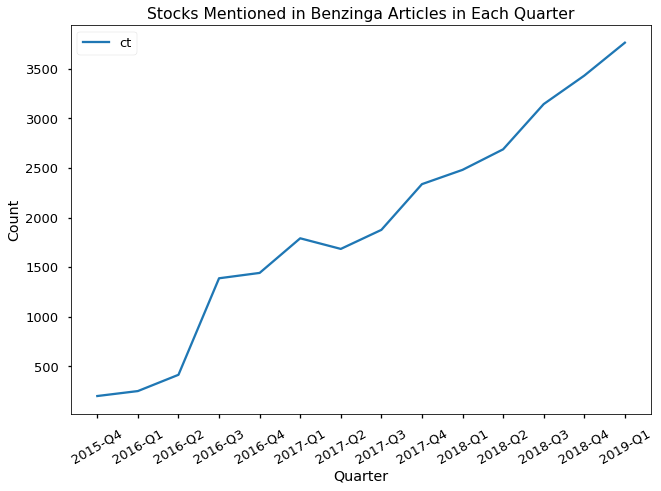

In [88]:
df_complete['ct'] = 1
ct_cal = df_complete.groupby(pd.Grouper(freq="Q", key = 'date')).sum()[['ct']]
ct_cal = ct_cal[ct_cal.index <= pd.to_datetime('04-01-2019')]
ct_cal.plot()
plt.xticks(event_cal.index,['2015-Q4', '2016-Q1', '2016-Q2', '2016-Q3', '2016-Q4', '2017-Q1', '2017-Q2', '2017-Q3', '2017-Q4',
                   '2018-Q1', '2018-Q2', '2018-Q3', '2018-Q4', '2019-Q1'], rotation = 30);
plt.title('Stocks Mentioned in Benzinga Articles in Each Quarter')
plt.xlabel('Quarter')
plt.ylabel('Count');

In [89]:
#exec change up
%time exec_u = get_price_deviations(up[up.descriptions.str.contains(exec_changes, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(exec_changes, case = False, na=False)].ticker)])
%time exec_d = get_price_deviations(down[down.descriptions.str.contains(exec_changes, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(exec_changes, case = False, na=False)].ticker)])

CPU times: user 3.31 s, sys: 121 ms, total: 3.43 s
Wall time: 3.44 s
CPU times: user 3.78 s, sys: 12.3 ms, total: 3.79 s
Wall time: 3.8 s


In [90]:
exec_u['pct_change_mean'] = exec_u[[col for col in exec_u.columns if col != 'days']].mean(1)
exec_d['pct_change_mean'] = exec_d[[col for col in exec_d.columns if col != 'days']].mean(1)

In [91]:
#pharma drug/patent approvals
%time pharma_u = get_price_deviations(up[up.descriptions.str.contains(pharma_approvals, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(pharma_approvals, case = False, na=False)].ticker)])
%time pharma_d = get_price_deviations(down[down.descriptions.str.contains(pharma_approvals, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(pharma_approvals, case = False, na=False)].ticker)])

CPU times: user 26.5 s, sys: 67 ms, total: 26.5 s
Wall time: 26.8 s
CPU times: user 15.1 s, sys: 35.6 ms, total: 15.1 s
Wall time: 15.1 s


In [92]:
pharma_u['pct_change_mean'] = pharma_u[[col for col in pharma_u.columns if col != 'days']].mean(1)
pharma_d['pct_change_mean'] = pharma_d[[col for col in pharma_d.columns if col != 'days']].mean(1)

In [93]:
#crypto
%time crypto_u = get_price_deviations(up[up.descriptions.str.contains(crypto, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(crypto, case = False, na=False)].ticker)])
%time crypto_d = get_price_deviations(down[down.descriptions.str.contains(crypto, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(crypto, case = False, na=False)].ticker)])

CPU times: user 750 ms, sys: 5.89 ms, total: 756 ms
Wall time: 756 ms
CPU times: user 473 ms, sys: 1.54 ms, total: 475 ms
Wall time: 475 ms


In [94]:
crypto_u['pct_change_mean'] = crypto_u[[col for col in crypto_u.columns if col != 'days']].mean(1)
crypto_d['pct_change_mean'] = crypto_d[[col for col in crypto_d.columns if col != 'days']].mean(1)

In [95]:
#legal
%time legal_u = get_price_deviations(up[up.descriptions.str.contains(legal, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(legal, case = False, na=False)].ticker)])
%time legal_d = get_price_deviations(down[down.descriptions.str.contains(legal, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(legal, case = False, na=False)].ticker)])

CPU times: user 1.74 s, sys: 5.64 ms, total: 1.75 s
Wall time: 1.75 s
CPU times: user 1.46 s, sys: 1.92 ms, total: 1.46 s
Wall time: 1.46 s


In [96]:
legal_u['pct_change_mean'] = legal_u[[col for col in legal_u.columns if col != 'days']].mean(1)
legal_d['pct_change_mean'] = legal_d[[col for col in legal_d.columns if col != 'days']].mean(1)

In [97]:
#amazon
%time amzn_u = get_price_deviations(up[(up.descriptions.str.contains('amazon', case = False, na=False)) & (up.ticker != 'AMZN')], prices[prices.ticker.isin(up[(up.descriptions.str.contains('amazon', case = False, na=False)) & (up.ticker != 'AMZN')].ticker)])
%time amzn_d = get_price_deviations(down[(down.descriptions.str.contains('amazon', case = False, na=False)) & (down.ticker != 'AMZN')], prices[prices.ticker.isin(down[(down.descriptions.str.contains('amazon', case = False, na=False)) & (down.ticker != 'AMZN')].ticker)])

CPU times: user 413 ms, sys: 3.19 ms, total: 417 ms
Wall time: 415 ms
CPU times: user 318 ms, sys: 704 µs, total: 319 ms
Wall time: 318 ms


In [98]:
amzn_u['pct_change_mean'] = amzn_u[[col for col in amzn_u.columns if col != 'days']].mean(1)
amzn_d['pct_change_mean'] = amzn_d[[col for col in amzn_d.columns if col != 'days']].mean(1)

In [99]:
#earnings
%time earnings_u = get_price_deviations(up[up.descriptions.str.contains(earnings, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(earnings, case = False, na=False)].ticker)])
%time earnings_d = get_price_deviations(down[down.descriptions.str.contains(earnings, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(earnings, case = False, na=False)].ticker)])

CPU times: user 4min 28s, sys: 631 ms, total: 4min 29s
Wall time: 4min 31s
CPU times: user 5min 17s, sys: 549 ms, total: 5min 18s
Wall time: 5min 18s


In [100]:
earnings_u['pct_change_mean'] = earnings_u[[col for col in earnings_u.columns if col != 'days']].mean(1)
earnings_d['pct_change_mean'] = earnings_d[[col for col in earnings_d.columns if col != 'days']].mean(1)

In [101]:
#analyst
%time analyst_u = get_price_deviations(up[up.descriptions.str.contains(analyst_ratings, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(analyst_ratings, case = False, na=False)].ticker)])
%time analyst_d = get_price_deviations(down[down.descriptions.str.contains(analyst_ratings, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(analyst_ratings, case = False, na=False)].ticker)])

CPU times: user 58.8 s, sys: 185 ms, total: 59 s
Wall time: 59.8 s
CPU times: user 50.5 s, sys: 146 ms, total: 50.7 s
Wall time: 50.8 s


In [102]:
analyst_u['pct_change_mean'] = analyst_u[[col for col in analyst_u.columns if col != 'days']].mean(1)
analyst_d['pct_change_mean'] = analyst_d[[col for col in analyst_d.columns if col != 'days']].mean(1)

In [103]:
#mergers and acquisitions
%time merge_u = get_price_deviations(up[up.descriptions.str.contains(merge_acq, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(merge_acq, case = False, na=False)].ticker)])
%time merge_d = get_price_deviations(down[down.descriptions.str.contains(merge_acq, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(merge_acq, case = False, na=False)].ticker)])

CPU times: user 25.4 s, sys: 47 ms, total: 25.4 s
Wall time: 25.5 s
CPU times: user 5.53 s, sys: 15.2 ms, total: 5.55 s
Wall time: 5.56 s


In [104]:
merge_u['pct_change_mean'] = merge_u[[col for col in merge_u.columns if col != 'days']].mean(1)
merge_d['pct_change_mean'] = merge_d[[col for col in merge_d.columns if col != 'days']].mean(1)

In [105]:
#buy back and dividend announcements outside of earnings announcement
%time bd_u = get_price_deviations(up[up.descriptions.str.contains(buyback_dividend, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(buyback_dividend, case = False, na=False)].ticker)])
%time bd_d = get_price_deviations(down[down.descriptions.str.contains(buyback_dividend, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(buyback_dividend, case = False, na=False)].ticker)])

CPU times: user 1.79 s, sys: 5.68 ms, total: 1.79 s
Wall time: 1.79 s
CPU times: user 1.32 s, sys: 7.74 ms, total: 1.33 s
Wall time: 1.36 s


In [106]:
bd_u['pct_change_mean'] = bd_u[[col for col in bd_u.columns if col != 'days']].mean(1)
bd_d['pct_change_mean'] = bd_d[[col for col in bd_d.columns if col != 'days']].mean(1)

In [107]:
#deals/agreements/partnerships/etc.
%time d_u = get_price_deviations(up[up.descriptions.str.contains(deals, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(deals, case = False, na=False)].ticker)])
%time d_d = get_price_deviations(down[down.descriptions.str.contains(deals, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(deals, case = False, na=False)].ticker)])

CPU times: user 13.6 s, sys: 27.4 ms, total: 13.6 s
Wall time: 13.6 s
CPU times: user 2.35 s, sys: 9.75 ms, total: 2.36 s
Wall time: 2.36 s


In [108]:
d_u['pct_change_mean'] = d_u[[col for col in d_u.columns if col != 'days']].mean(1)
d_d['pct_change_mean'] = d_d[[col for col in d_d.columns if col != 'days']].mean(1)

In [109]:
#stake in companies
%time stake_u = get_price_deviations(up[up.descriptions.str.contains(stake, case = False, na=False)], prices[prices.ticker.isin(up[up.descriptions.str.contains(stake, case = False, na=False)].ticker)])
%time stake_d = get_price_deviations(down[down.descriptions.str.contains(stake, case = False, na=False)], prices[prices.ticker.isin(down[down.descriptions.str.contains(stake, case = False, na=False)].ticker)])

CPU times: user 1.81 s, sys: 5.56 ms, total: 1.81 s
Wall time: 1.81 s
CPU times: user 633 ms, sys: 1.44 ms, total: 634 ms
Wall time: 635 ms


In [110]:
stake_u['pct_change_mean'] = stake_u[[col for col in stake_u.columns if col != 'days']].mean(1)
stake_d['pct_change_mean'] = stake_d[[col for col in stake_d.columns if col != 'days']].mean(1)

In [111]:
#stock offerings
%time offering_u = get_price_deviations(up[(up.descriptions.str.contains(offering, case = False, na=False)) & (~up.descriptions.str.contains('\Wipo\W|public offering', case = False, na=False))], prices[prices.ticker.isin(up[(up.descriptions.str.contains(offering, case = False, na=False)) & (~up.descriptions.str.contains('\Wipo\W|public offering', case = False, na=False))].ticker)])
%time offering_d = get_price_deviations(down[(down.descriptions.str.contains(offering, case = False, na=False)) & (~down.descriptions.str.contains('\Wipo\W|public offering', case = False, na=False))], prices[prices.ticker.isin(down[(down.descriptions.str.contains(offering, case = False, na=False)) & (~down.descriptions.str.contains('\Wipo\W|public offering', case = False, na=False))].ticker)])

CPU times: user 1.57 s, sys: 4.8 ms, total: 1.57 s
Wall time: 1.58 s
CPU times: user 27.5 s, sys: 55.4 ms, total: 27.5 s
Wall time: 27.6 s


In [112]:
offering_u['pct_change_mean'] = offering_u[[col for col in offering_u.columns if col != 'days']].mean(1)
offering_d['pct_change_mean'] = offering_d[[col for col in offering_d.columns if col != 'days']].mean(1)

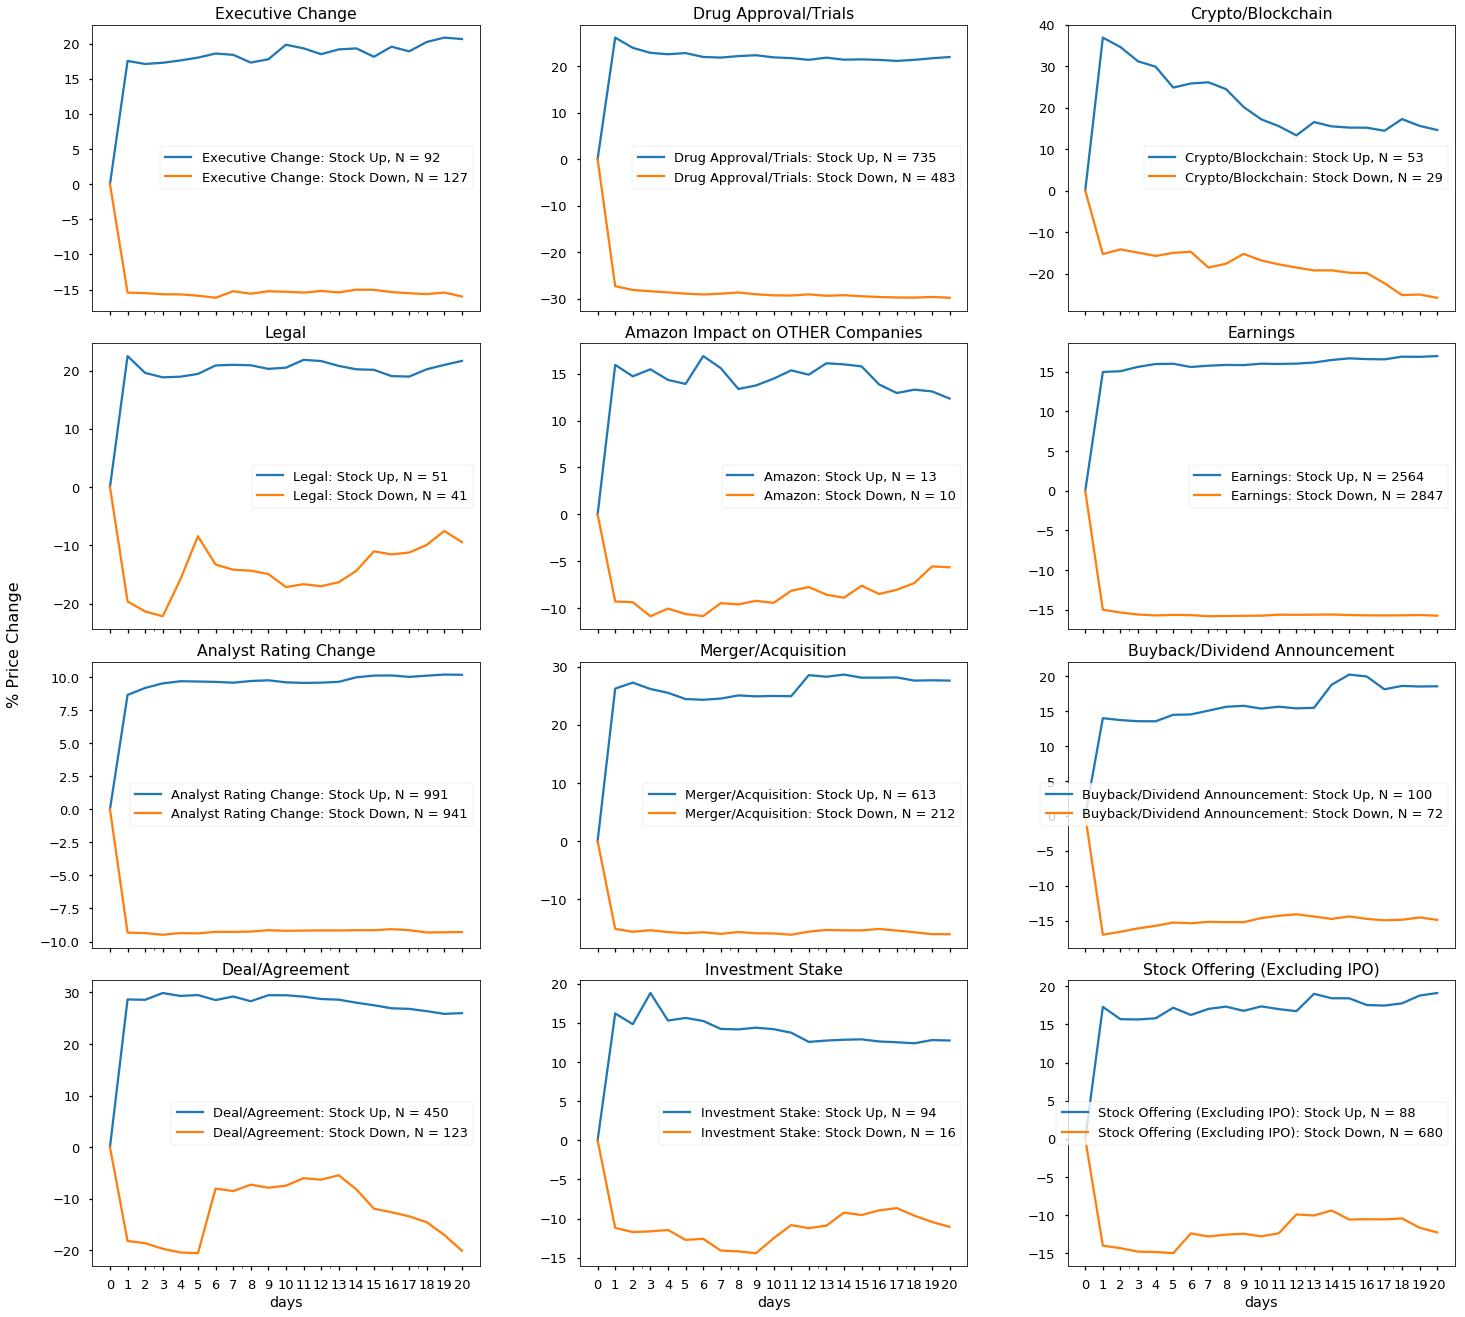

In [120]:
fig, axes = plt.subplots(4,3, sharex=True)

exec_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0], figsize = [20, 20])
exec_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,0])
axes[0,0].set_xticks(range(21))
axes[0,0].legend(['Executive Change: Stock Up, N = %d'%(exec_u.shape[1]-2), 'Executive Change: Stock Down, N = %d'%(exec_d.shape[1]-2)])
axes[0,0].set_title('Executive Change')


pharma_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
pharma_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,1])
axes[0,1].set_xticks(range(21))
axes[0,1].legend(['Drug Approval/Trials: Stock Up, N = %d'%(pharma_u.shape[1]-2), 
            'Drug Approval/Trials: Stock Down, N = %d'%(pharma_d.shape[1]-2)])
axes[0,1].set_title('Drug Approval/Trials')


crypto_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,2])
crypto_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[0,2])
axes[0,2].set_xticks(range(21))
axes[0,2].legend(['Crypto/Blockchain: Stock Up, N = %d'%(crypto_u.shape[1]-2), 'Crypto/Blockchain: Stock Down, N = %d'%(crypto_d.shape[1]-2)])
axes[0,2].set_title('Crypto/Blockchain')


legal_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
legal_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,0])
axes[1,0].set_xticks(range(21))
axes[1,0].legend(['Legal: Stock Up, N = %d'%(legal_u.shape[1]-2), 'Legal: Stock Down, N = %d'%(legal_d.shape[1]-2)])
axes[1,0].set_title('Legal')


amzn_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
amzn_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,1])
axes[1,1].set_xticks(range(21))
axes[1,1].legend(['Amazon: Stock Up, N = %d'%(amzn_u.shape[1]-2), 'Amazon: Stock Down, N = %d'%(amzn_d.shape[1]-2)])
axes[1,1].set_title('Amazon Impact on OTHER Companies')

earnings_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,2])
earnings_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[1,2])
axes[1,2].set_xticks(range(21))
axes[1,2].legend(['Earnings: Stock Up, N = %d'%(earnings_u.shape[1]-2), 'Earnings: Stock Down, N = %d'%(earnings_d.shape[1]-2)])
axes[1,2].set_title('Earnings')

analyst_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
analyst_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,0])
axes[2,0].set_xticks(range(21))
axes[2,0].legend(['Analyst Rating Change: Stock Up, N = %d'%(analyst_u.shape[1]-2), 'Analyst Rating Change: Stock Down, N = %d'%(analyst_d.shape[1]-2)])
axes[2,0].set_title('Analyst Rating Change')

merge_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
merge_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,1])
axes[2,1].set_xticks(range(21))
axes[2,1].legend(['Merger/Acquisition: Stock Up, N = %d'%(merge_u.shape[1]-2), 'Merger/Acquisition: Stock Down, N = %d'%(merge_d.shape[1]-2)])
axes[2,1].set_title('Merger/Acquisition')

bd_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,2])
bd_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[2,2])
axes[2,2].set_xticks(range(21))
axes[2,2].legend(['Buyback/Dividend Announcement: Stock Up, N = %d'%(bd_u.shape[1]-2), 'Buyback/Dividend Announcement: Stock Down, N = %d'%(bd_d.shape[1]-2)])
axes[2,2].set_title('Buyback/Dividend Announcement')

d_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[3,0])
d_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[3,0])
axes[3,0].set_xticks(range(21))
axes[3,0].legend(['Deal/Agreement: Stock Up, N = %d'%(d_u.shape[1]-2), 'Deal/Agreement: Stock Down, N = %d'%(d_d.shape[1]-2)])
axes[3,0].set_title('Deal/Agreement')

stake_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[3,1])
stake_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[3,1])
axes[3,1].set_xticks(range(21))
axes[3,1].legend(['Investment Stake: Stock Up, N = %d'%(stake_u.shape[1]-2), 'Investment Stake: Stock Down, N = %d'%(stake_d.shape[1]-2)])
axes[3,1].set_title('Investment Stake')

offering_u[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[3,2])
offering_d[['days', 'pct_change_mean']].plot(kind = 'line', x = 'days', ax=axes[3,2])
axes[3,2].set_xticks(range(21))
axes[3,2].legend(['Stock Offering (Excluding IPO): Stock Up, N = %d'%(offering_u.shape[1]-2), 'Stock Offering (Excluding IPO): Stock Down, N = %d'%(offering_d.shape[1]-2)])
axes[3,2].set_title('Stock Offering (Excluding IPO)')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.text(-0.01, 0.5, '% Price Change', ha='center', va='center', rotation='vertical', size = 16);


In [114]:
df_complete['price_move_abs'] = df_complete.price_move.abs()

In [115]:
up_complete = df_complete[df_complete.price_move > 0]
down_complete = df_complete[df_complete.price_move < 0]

In [116]:
#data from: http://www.cboe.com/products/vix-index-volatility/vix-options-and-futures/vix-index/vix-historical-data
vxx = pd.read_csv('vixcurrent.csv', skiprows=1)
vxx['Date'] = pd.to_datetime(vxx.Date)

vxx_cal = vxx.groupby(pd.Grouper(freq="Q", key = 'Date')).mean()[['VIX Close']]
vxx_cal.columns = ['close']
vxx_cal = vxx_cal.reset_index()

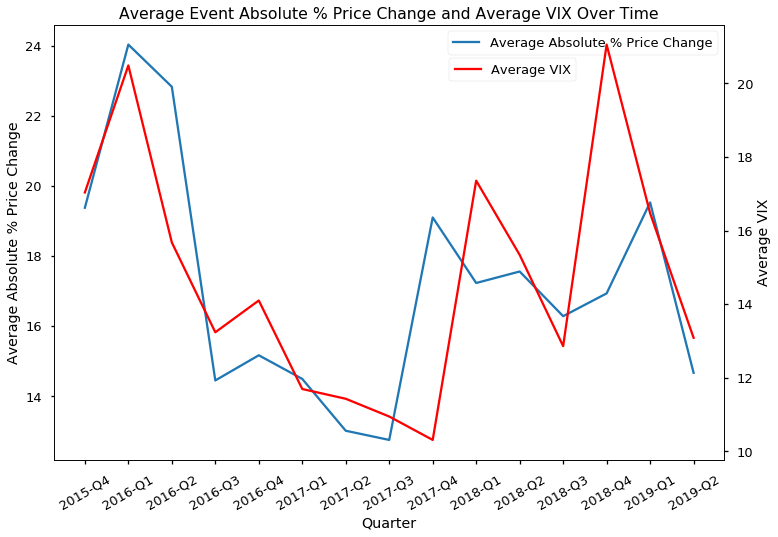

In [117]:
vol_cal = pd.DataFrame(df_complete.groupby(pd.Grouper(freq="Q", key = 'date')).price_move_abs.mean())

#only use complete quarters
# vol_cal = vol_cal[vol_cal.index <= pd.to_datetime('2019-03-31')]

vol_cal.columns = ['overall_avg_abs_price_move']

fig, ax1 = plt.subplots()
vol_cal = pd.merge(vol_cal, vxx_cal, left_index = True, right_on = 'Date', how = 'left', copy = False)

vol_cal.overall_avg_abs_price_move.plot(ax = ax1, figsize = [12, 8])

plt.legend(['Average Absolute % Price Change'])
plt.title('Average Event Absolute % Price Change and Average VIX Over Time')
plt.xlabel('Quarter')
plt.ylabel('Average Absolute % Price Change');
plt.xticks(vol_cal.index,['2015-Q4', '2016-Q1', '2016-Q2', '2016-Q3', '2016-Q4', '2017-Q1', '2017-Q2', '2017-Q3', '2017-Q4',
                   '2018-Q1', '2018-Q2', '2018-Q3', '2018-Q4', '2019-Q1', '2019-Q2'], rotation = 30);

ax2 = ax1.twinx()
vol_cal.close.plot(figsize = [12, 8], ax = ax2, color = 'red')
ax2.legend(['Average VIX'], loc = [0.59, 0.87])
ax2.set_ylabel('Average VIX');


In [118]:
#get btc data: https://finance.yahoo.com/quote/BTC-USD/history/
btc = pd.read_csv('BTC-USD.csv')
btc['Date'] = pd.to_datetime(btc.Date)

btc_cal = btc.groupby(pd.Grouper(freq="Q", key = 'Date')).mean()[['Close']]
btc_cal = btc_cal.reset_index()
btc_cal = btc_cal[(btc_cal.Date <= pd.to_datetime('2019-03-31')) & (btc_cal.Date >= '2015-10-12')]


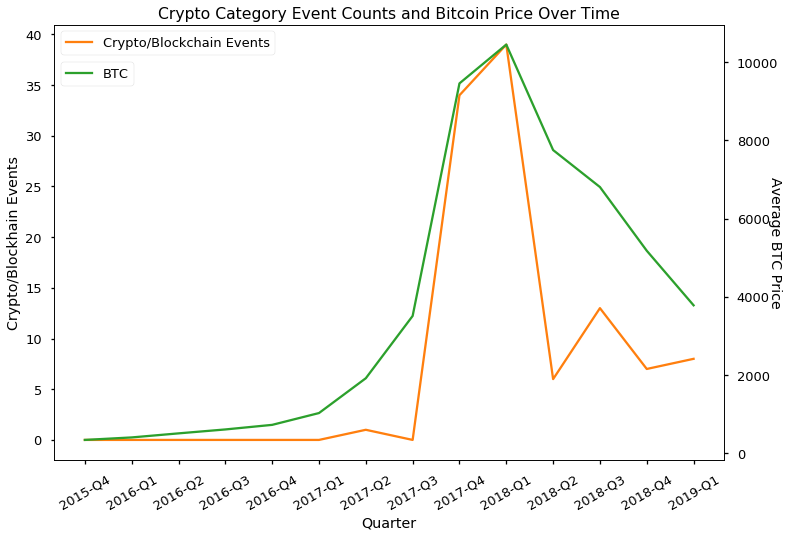

In [119]:
event_cal = df_complete.groupby(pd.Grouper(freq="Q", key = 'date')).sum()[['crypto']]
#only use complete quarters
event_cal = event_cal[event_cal.index <= pd.to_datetime('2019-03-31')]

#merge with btc prices
event_cal = pd.merge(event_cal, btc_cal, left_index = True, right_on = 'Date', how = 'left', copy = False)


fig, ax1 = plt.subplots()
event_cal.crypto.plot(ax = ax1, figsize = [12, 8], color = 'tab:orange')


event_cal = event_cal.rename(columns = {'Close':'btc'})


plt.legend(['Crypto/Blockchain Events'])
plt.title('Crypto Category Event Counts and Bitcoin Price Over Time')
plt.xlabel('Quarter')
plt.ylabel('Crypto/Blockhain Events');
plt.xticks(event_cal.index,['2015-Q4', '2016-Q1', '2016-Q2', '2016-Q3', '2016-Q4', '2017-Q1', '2017-Q2', '2017-Q3', '2017-Q4',
                   '2018-Q1', '2018-Q2', '2018-Q3', '2018-Q4', '2019-Q1'], rotation = 30);


ax2 = ax1.twinx()
event_cal.btc.plot(figsize = [12, 8], ax = ax2, color = 'tab:green')
ax2.legend(['BTC'], loc = [0.01, 0.86])
ax2.set_ylabel('Average BTC Price', rotation = -90);


